<font size="5">**Reading from bedgraph**</font>
<br>
Bedgraph format:
<br>
*chromA  chromStartA  chromEndA  dataValueA*
<br>
*chromB  chromStartB  chromEndB  dataValueB*

In [1]:
import numpy as np
import csv

with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-miseq.bedgraph') as bed1:
#with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\test.txt') as bed1:
    bed1_reader = csv.reader(bed1, delimiter='\t')
    bed1_columns = list(zip(*bed1_reader))
    bed1_ranges = [(bed1_columns[1][i], bed1_columns[2][i]) for i in range(len(bed1_columns[1]))]
    bed1_score = bed1_columns[3]    
    
with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-nanopore.bedgraph') as bed2:
    bed2_reader = csv.reader(bed2, delimiter='\t')
    bed2_columns = list(zip(*bed2_reader))
    bed2_ranges = [(bed2_columns[1][i], bed2_columns[2][i]) for i in range(len(bed2_columns[1]))]
    bed2_score = bed2_columns[3]

#predpokladame, ze subor bude usporiadany podla mena chromozom a intervalov
if (bed1_columns[2][len(bed1_columns[2])-1]) != (bed2_columns[2][len(bed2_columns[2])-1]):
    raise ValueError('Wrong files, the intervals of both files should be the same length')

<font size="5">**Drawing histograms**</font>

**We don't have to separate chromNames**
<br>
The following function converts the data into format that can be used by the drawing function from the fall semester and draws the histogram

In [2]:
from DrawDistributions import draw
from DrawErrors import drawErrors

def drawHistogramsForReads(ranges, score):
    # predpokladame, ze velkost ranges == velkost score
    # Zadaj limitu pre os x>
    max_x=100

    # Zadaj pocet shiftnuti
    num_of_shifts = 1

    #spravim histogram a zobrazim ho pomocou draw
    histo = {}
    for i in range(len(ranges)) :
        if int(score[i]) in histo:
            histo[int(score[i])] += (int(ranges[i][1])-int(ranges[i][0]))
        else:
            histo[int(score[i])] = (int(ranges[i][1])-int(ranges[i][0]))
    # treba vymazat 0, inak to pada
    if(0 in histo):
        del histo[0]
    data = draw(histo, max_x, num_of_shifts)
    #print(len(histo))    
    print('Maximum number of reads:', max(histo))

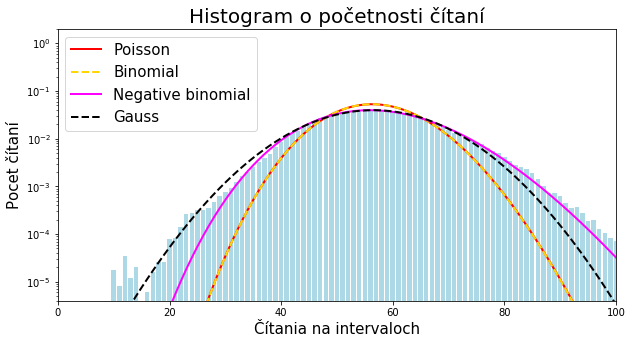

Maximum number of reads: 107


In [3]:
drawHistogramsForReads(bed1_ranges, bed1_score)

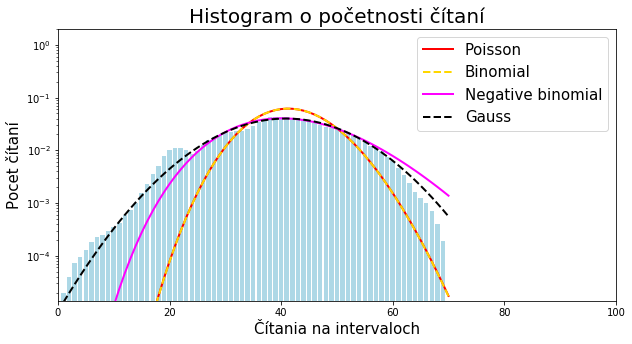

Maximum number of reads: 70


In [4]:
drawHistogramsForReads(bed2_ranges, bed2_score)

<font size="5">**Visualizing 2bedgraphs with 2D heatmap**</font>

Format of the bedgraph:
*chrom chromStart chromEnd dataValue*

We can assign to each position 2 numbers - the number of reads (*dataValue*) from both bedgarphs. Below with the 2D heatmap is visualized the frequency for *dataValue*

In [5]:
bg1 = []
for r in range(len(bed1_ranges)):  
    bg1 += (int(bed1_ranges[r][1])-int(bed1_ranges[r][0])) * [int(bed1_score[r])]
    
bg2 = []
for r in range(len(bed2_ranges)):  
    bg2 += (int(bed2_ranges[r][1])-int(bed2_ranges[r][0])) * [int(bed2_score[r])]
    

<font size="3">**Function to create 2D heatmap**</font>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

def make_heatmap(bg1, bg2):
    #predpokladam, ze tie mena chromozom su v rovnakom poradi a velkost suboru je rovanaka
    x = np.array(bg1)
    y = np.array(bg2)

    #bins = nasekat rovnomerne

    plt.figure(figsize=(20,10))    
    plt.hist2d(x, y,bins=(range(max(x)), range(max(y))), cmap='plasma')

    cb = plt.colorbar()
    cb.set_label('Number of reads', fontsize=15)

    plt.title('Heatmap of the 2 bedgraphs', fontsize=20)
    plt.xlabel('1st bedgraph', fontsize=15)
    plt.ylabel('2nd bedgraph', fontsize=15)

    plt.show()

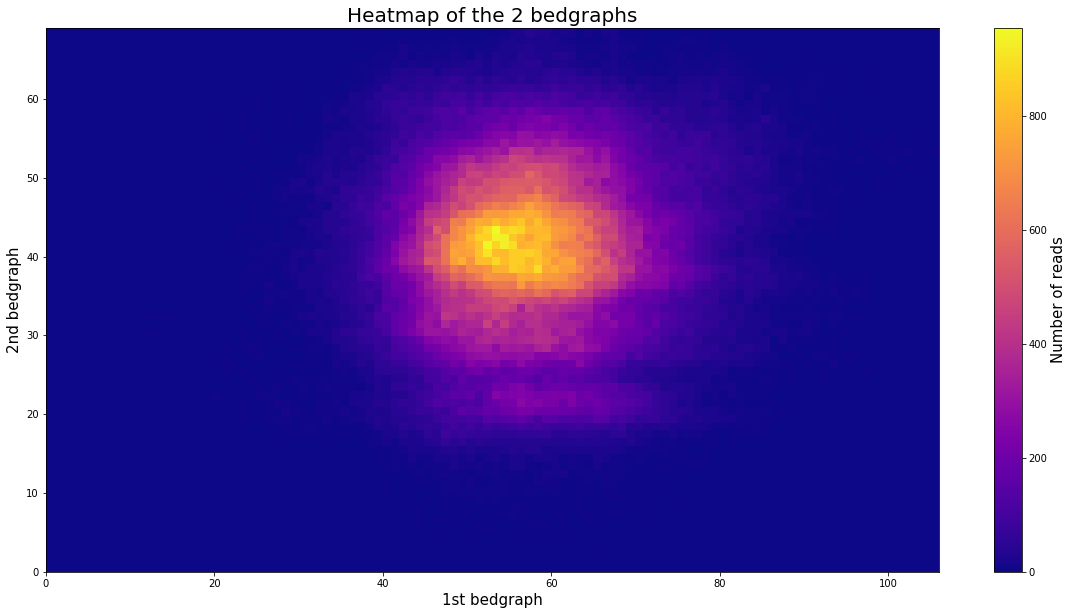

In [7]:
make_heatmap(bg1, bg2)

<font size="5">**Reading from fasta file:**</font>

Ref.fasta = referencia tých 2 bedgrafov, obsahuje *chromName* a *ACGT* reťazce.
<br>
Budeme mať okienko fixnej nepárnej dĺžky, ktoré budeme posúvať v po sekvencii. 
<br>
Zrátame nejakú jednoduchú funkciu: napr. aký počet (percento) tvoria *G* alebo *C*, neskôr nejakú zložitosť.

<font size="3">**Function to convert fasta file to list**</font>
<br>
Function converts fasta file to list. The returned list contains only characters of the sequence

In [8]:
def read_fasta_file(filename):
    data = []
    with open(filename) as fasta:
        for line in fasta: 
            if not line.startswith(">"):
                for c in line.strip():
                    data.append(c)
    return data

<font size="3">**Function to create values like**</font>
<br>
Function creates a list of values. These values are created by applying a function on a window (sublist). We save the value to the middle position (middle of k-mer length)

In [9]:
def create_values_from_fasta(fasta_data, kmer_length, function):
    if (kmer_length % 2 != 1):
        raise ValueError('The length of k-mer should be odd!')
    
    values = []
    half = int(kmer_length/2) 
    
    for i in range(len(fasta_data) - kmer_length +1):  # +1lebo ideme aj za posledne pismenko
        window = fasta_data[i:i+kmer_length]

        #ak su to kraje, tak napln half-krat values
        if i == 0 or i == (len(fasta_data) - kmer_length):
            values += [function(window)] * half
            
        #ak su to vnutorne casti
        if i >= 0 and i <= (len(fasta_data) - kmer_length):
            values.append(function(window))  
    return values
    

<font size="3">**GC count function**</font>
<br>
Simple function to count G and C in list of characters

In [10]:
def count_function(string):
    count = 0
    for c in string:
        if(c == 'G' or c == 'C'):
            count += 1
    return count

<font size="3">**TEST**</font>
<br>
Testing read_fasta_file and create_values_from_fasta

In [11]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\fasta-test.txt')
got_values = create_values_from_fasta(fasta_data, 21, count_function)
expected = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 13, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
ok = True
for i in range(len(expected)):
    if(expected[i]!=got_values[i]):
        ok=False

if(ok):
    print("TEST OK")
else:
    print("TEST FAILED")
    print("Expected:", expected)
    print("Got:     ", got_values)

TEST OK


<font size="4">**Visualizing heatmap for GC content**</font>

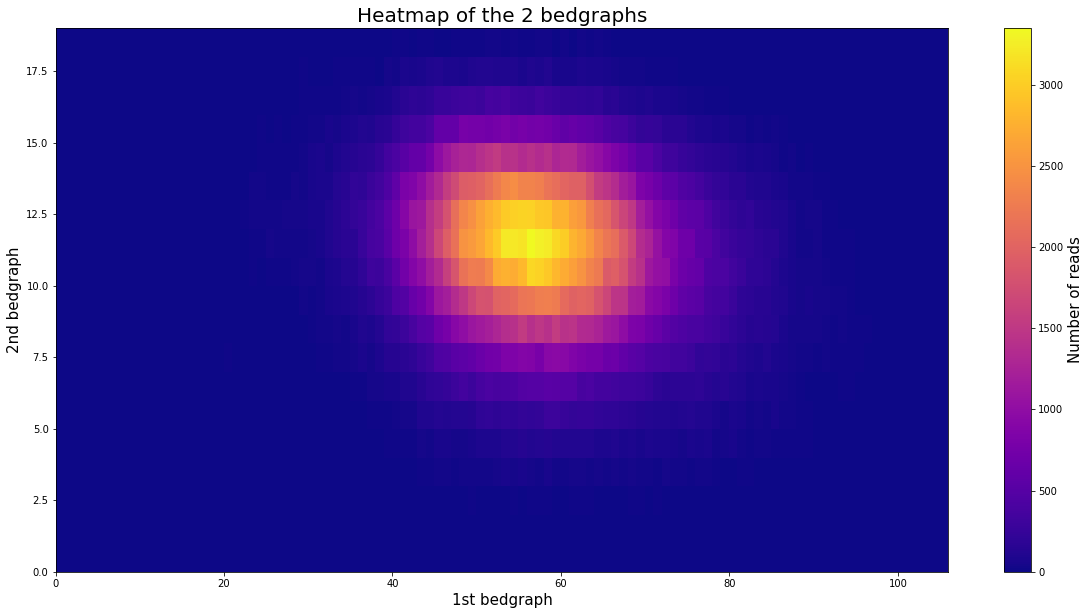

In [12]:
fasta_data = read_fasta_file('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref.fasta')
values = create_values_from_fasta(fasta_data, 21, count_function)

make_heatmap(bg1, values)

<br><br><br><br>
<br><br><br><br>

<font size="6">**Old, unused functions:**</font>

**findDifferentChromIntervals function** returns a list of tuples that represent the <start, end) position for chromName

In [13]:
def findDifferentChromIntervals(columns):    
    chromIntervals = []
    chromName = columns[0][0]
    startIndex = 0
    index = 0

    for index in range(len(columns[0])):
        if columns[0][index] != chromName:
            chromIntervals.append((startIndex,index))
            startIndex = index
            chromName = columns[0][index]
    chromIntervals.append((startIndex, index+1))
           
    return chromIntervals

**Function to draw histograms for reads for every chromName**

In [14]:
from DrawDistributions import draw
from DrawErrors import drawErrors

def drawHistogramsForChromNames(chromIntervals, ranges, score):
    # Zadaj limitu pre os x>
    max_x=100

    # Zadaj pocet shiftnuti
    num_of_shifts = 4

    print(range(len(chromIntervals)))
    print(chromIntervals[0])

    #pre kazdy chromName si spravim histogram a zobrazim ho pomocou draw + drawErrors
    for chrom in range(len(chromIntervals)):
        histo = {}
        for i in range(chromIntervals[chrom][0],chromIntervals[chrom][1]) :
            #print('chrom = ', chrom, '   i = ', i)
            if int(score[i]) in histo:
                histo[int(score[i])] += (int(ranges[i][1])-int(ranges[i][0]))
            else:
                histo[int(score[i])] = (int(ranges[i][1])-int(ranges[i][0]))
        # treba vymazat 0, inak to pada
        if(0 in histo):
            del histo[0]
        data = draw(histo, max_x, num_of_shifts)
        drawErrors(data)
    print(len(histo))    
    print('Maximum number of read:', max(histo))

**Drawing histograms for reads for every chromName**

In [15]:
bed1_chromIntervals = findDifferentChromIntervals(bed1_columns)
print(bed1_chromIntervals) 

bed2_chromIntervals = findDifferentChromIntervals(bed2_columns)
print(bed2_chromIntervals)

print(len(bed1_score))
print(len(bed2_score))

[(0, 230387)]
[(0, 394197)]
230387
394197
